##INIT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from collections import defaultdict
import plotly.express as px
from sklearn.decomposition import PCA


import os
import shutil
import random

In [ ]:
if os.path.isdir('data'):
  shutil.rmtree('data')

if os.path.isdir('data_fixed'):
  shutil.rmtree('data_fixed')

if os.path.isdir('original_data'):
  shutil.rmtree('original_data')

!wget https://technionmail-my.sharepoint.com/:u:/g/personal/eliezer_campus_technion_ac_il/Ee8xO2OrUzlFljYSLBHxYZgBBrU5xnilCbkL6Y265rdgQA?download=1 -O data.zip
!unzip data
shutil.move('data_fixed', 'original_data')

In [3]:
def stats(data_path='data', verbose=False):
  dict_count = {}
  for phase in ['train', 'val']:
    dict_count[phase] = {}
    count = 0
    for class_name in os.listdir(f'{data_path}/{phase}'):
      if verbose:
        print(f'{phase}\t{class_name}\tN={len(os.listdir(f"{data_path}/{phase}/{class_name}"))}')
      count += len(os.listdir(f"{data_path}/{phase}/{class_name}"))
      dict_count[phase][class_name] = len(os.listdir(f"{data_path}/{phase}/{class_name}"))
    if verbose:
      print(f'{phase}\t{count} total images')
  return dict_count

dic_count = stats('original_data')

In [4]:
augmented_data_path = 'data'
for class_name in os.listdir('original_data/train'):
  os.makedirs(f'{augmented_data_path}/train/{class_name}', exist_ok=True)
  os.makedirs(f'{augmented_data_path}/val/{class_name}', exist_ok=True)

In [5]:
# move from train to val some of the images and some keep in n
for class_name in os.listdir(f'original_data/train'):

  files_names = os.listdir(f'original_data/train/{class_name}')
  random.shuffle(files_names)
  n_images = int(0.2 * (len(files_names) + 1))
  for file_name in files_names[:n_images]:
    shutil.copy(f'original_data/train/{class_name}/{file_name}', f'{augmented_data_path}/val/{class_name}/{file_name}')
  for file_name in files_names[n_images:]:
    shutil.copy(f'original_data/train/{class_name}/{file_name}', f'{augmented_data_path}/train/{class_name}/{file_name}')

for class_name in os.listdir('original_data/val'):
  for file_name in os.listdir(f'original_data/val/{class_name}'):
      shutil.copy(f'original_data/val/{class_name}/{file_name}', f'{augmented_data_path}/val/{class_name}/{file_name}')
dict_count = stats('data')

##Augmentation

In [6]:
shape = (64, 64)


def numpy2img(image_array):
    return Image.fromarray(np.uint8(image_array)).resize(shape)


def centralize_image(img):
    image_array = np.array(img)
    dh, dw = image_array.shape
    image_array = image_array.T[((255 - image_array).sum(0) != 0)].T
    image_array = image_array[((255 - image_array).sum(1) != 0)]
    dh, dw = dh - image_array.shape[0], dw - image_array.shape[1]
    return numpy2img(image_array), dh, dw


def decentralize_image(img, dh, dw):
    image_array = np.array(img)
    new_image_array = np.zeros((image_array.shape[0] + dh, image_array.shape[1] + dw)) + 255
    new_image_array[dh // 2: image_array.shape[0] + dh // 2, dw // 2: image_array.shape[1] + dw // 2] = image_array
    return numpy2img(new_image_array)


def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    imga = np.array(imga)
    imgb = np.array(imgb)
    ha, wa = imga.shape[:2]
    hb, wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa + wb
    new_img = np.zeros((max_height, total_width))
    new_img[:ha, :wa] = imga
    new_img[:hb, wa:wa + wb] = imgb
    return numpy2img(new_img)


def combine_images(img1, img2):
    img1, img2 = img1.resize(shape), img2.resize(shape)
    n1_img, dh1, dw1 = centralize_image(img1)
    n2_img, dh2, dw2 = centralize_image(img2)
    combined_image = concat_images(n1_img, n2_img)
    dh, dw = max(dh1, dh2), max(dw1, dw2)
    combined_image = decentralize_image(combined_image, dh, dw)
    return combined_image


def corners_and_center(image):
    img = np.array(image)
    img = img.T[((255 - img).sum(0) != 0)].T
    img = img[((255 - img).sum(1) != 0)]
    h, w = img.shape
    tl, tr, bl, br, cen = (255 + np.zeros((5, 2 * h, 2 * w)))[:]
    tl[:h, :w] = img
    tr[:h, w:2 * w] = img
    bl[h:2 * h, :w] = img
    br[h:2 * h, w:2 * w] = img
    cen[h // 2:h + h // 2, w // 2: w + w // 2] = img
    tl, tr, bl, br, cen = [Image.fromarray(np.uint8(new_image_array)) for new_image_array in [tl, tr, bl, br, cen]]
    return tl, tr, bl, br, cen


In [7]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import random
import os


shape = (64, 64)
N = 750


def mirror_and_flip(data_path='data', phase='train'):
    print('Augment data with mirroring and flipping')
    # mirror and get new label
    dict_count = stats(verbose=False)
    for source, target in [('iv', 'vi'), ('vi', 'iv')]:
        for idx, file_name in enumerate(os.listdir(f'{data_path}/{phase}/{source}')):
            if dict_count['train'][target] >= N:
                break
            dict_count['train'][target] += 1
            img = Image.open(f'{data_path}/{phase}/{source}/{file_name}')
            new_img = ImageOps.mirror(img)
            new_img.save(f'{data_path}/{phase}/{target}/{file_name.split(".")[0]}_mirror_{source}_{target}.png')

    # mirror
    dict_count = stats(verbose=False)
    for label in ['i', 'ii', 'iii', 'v', 'x']:
        for idx, file_name in enumerate(os.listdir(f'{data_path}/{phase}/{label}')[:N - dict_count['train'][label]]):
            if dict_count['train'][label] >= N:
                break
            dict_count['train'][label] += 1
            img = Image.open(f'{data_path}/{phase}/{label}/{file_name}')
            new_img = ImageOps.mirror(img)
            new_img.save(f'{data_path}/{phase}/{label}/{file_name.split(".")[0]}_mirror_regular.png')

    # flip
    dict_count = stats(verbose=False)
    for label in ['i', 'ii', 'iii', 'ix', 'x']:
        for idx, file_name in enumerate(os.listdir(f'{data_path}/{phase}/{label}')[:N - dict_count['train'][label]]):
            if dict_count['train'][label] >= N:
                break
            dict_count['train'][label] += 1
            img = Image.open(f'{data_path}/{phase}/{label}/{file_name}')
            new_img = ImageOps.flip(img)
            new_img.save(f'{data_path}/{phase}/{label}/{file_name.split(".")[0]}_flip_regular.png')


def image_corners(data_path='data', k=3):
    N = 850
    print("Augmenting with different locations")
    dic = stats()
    phase_path = f'{data_path}/train'
    for label in os.listdir(phase_path):
        n = max(0, (N - dic['train'][label])) // k
        label_path = f'{phase_path}/{label}'
        for image_name in os.listdir(label_path)[:n]:
            img_path = f'{label_path}/{image_name}'
            img = Image.open(img_path)
            tl, tr, bl, br, center = corners_and_center(img)
            for idx, aug in enumerate(random.sample([tl, tr, bl, br], k=k), start=1):
                aug.save(f"{label_path}/{image_name}_aug{idx}.png")


def augment_combinations(data_path='data', phase='train'):
    print('Augment data with combinations')
    N = 900
    count = 133333
    dict_count = stats(verbose=False)
    for (source1, source2), target in [
        (('i', 'x'), 'ix'),
        (('vii', 'i'), 'viii'),
        (('vi', 'ii'), 'viii'),
        (('v', 'ii'), 'vii'),
        (('v', 'i'), 'vi'),
        (('i', 'v'), 'iv'),
        # (('ii', 'i'), 'iii'),
        # (('i', 'ii'), 'iii'),
        # (('i', 'i'), 'ii'),
    ]:
        images_sources1 = os.listdir(f'{data_path}/{phase}/{source1}')
        images_sources2 = os.listdir(f'{data_path}/{phase}/{source2}')
        for img1_path in images_sources1:
            for img2_path in images_sources2[1:]:
                if dict_count['train'][target] >= N:
                    break
                dict_count['train'][target] += 1
                img1 = Image.open(f'{data_path}/{phase}/{source1}/{img1_path}')
                img2 = Image.open(f'{data_path}/{phase}/{source2}/{img2_path}')
                combine_images(img1, img2).save(f"{data_path}/{phase}/{target}/combinations_{count}.png")
                count += 1


def blur_augmentation(data_path='data'):
    print("Augmentation with blurring")
    N = 960
    dict_count = stats(verbose=False)
    count = 100000
    for target in [key for key, value in stats(verbose=False)['train'].items() if value < N]:
        images = os.listdir(f'{data_path}/train/{target}')
        for fname in images[:max(0, N - dict_count['train'][target])]:
            count += 1
            img = Image.open(f'{data_path}/train/{target}/{fname}')
            img.save(f'{data_path}/train/{target}/{count}_blurred.png')


def rotate_augmentation(data_path='data'):
    global N
    print("Rotate Augmentation")
    dict_count = stats(verbose=False)
    count = 302922
    for target in [key for key, value in stats(verbose=False)['train'].items() if value < N]:
        images = os.listdir(f'{data_path}/train/{target}')
        for fname in images[:max(0, N - dict_count['train'][target])]:
            count += 1
            img = Image.open(f'{data_path}/train/{target}/{fname}')
            sign = (random.randint(0, 1) * 2) - 1
            img.rotate(sign * 15, fillcolor=255)
            img.save(f'{data_path}/train/{target}/{count}_blurred.png')
    dict_count = stats(verbose=False)


In [8]:
mirror_and_flip(data_path="data", phase="train")
image_corners(data_path="data", k=3)
blur_augmentation(data_path="data")
augment_combinations(data_path="data", phase="train")
dict_count = stats("data", True)

Augment data with mirroring and flipping
Augmenting with different locations
Augmentation with blurring
Augment data with combinations
train	vii	N=960
train	ii	N=960
train	i	N=960
train	x	N=960
train	v	N=960
train	iii	N=960
train	iv	N=960
train	ix	N=960
train	viii	N=960
train	vi	N=960
train	9600 total images
val	vii	N=38
val	ii	N=33
val	i	N=50
val	x	N=33
val	v	N=37
val	iii	N=33
val	iv	N=55
val	ix	N=43
val	viii	N=36
val	vi	N=35
val	393 total images


{'train': {'i': 960,
  'ii': 960,
  'iii': 960,
  'iv': 960,
  'ix': 960,
  'v': 960,
  'vi': 960,
  'vii': 960,
  'viii': 960,
  'x': 960},
 'val': {'i': 50,
  'ii': 33,
  'iii': 33,
  'iv': 55,
  'ix': 43,
  'v': 37,
  'vi': 35,
  'vii': 38,
  'viii': 36,
  'x': 33}}

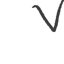

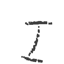

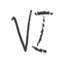

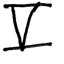

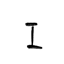

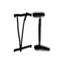

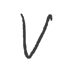

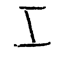

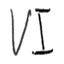

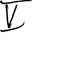

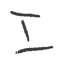

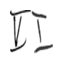

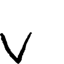

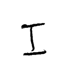

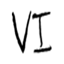

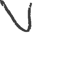

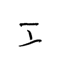

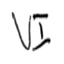

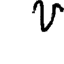

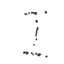

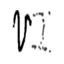

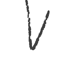

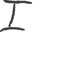

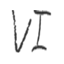

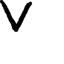

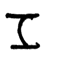

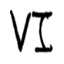

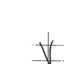

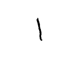

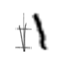

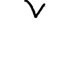

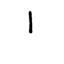

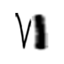

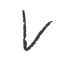

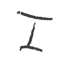

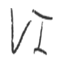

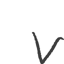

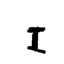

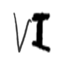

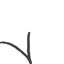

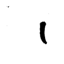

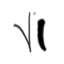

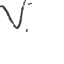

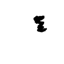

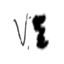

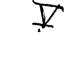

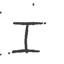

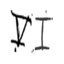

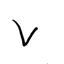

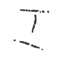

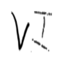

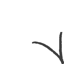

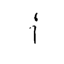

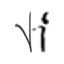

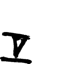

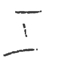

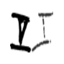

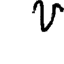

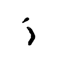

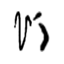

<Figure size 432x288 with 0 Axes>

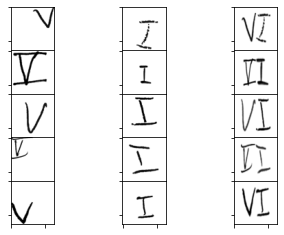

<Figure size 432x288 with 0 Axes>

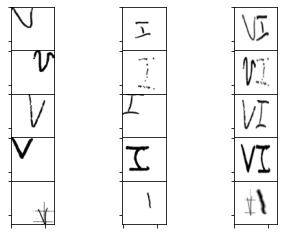

<Figure size 432x288 with 0 Axes>

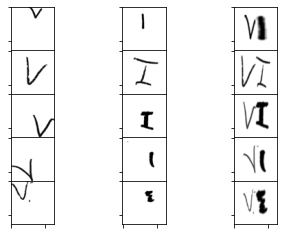

In [9]:
all_images = []

for i, idx in enumerate(range(40, 60)):
    n1, idx1 = 'v', idx
    n2, idx2 = 'i', idx
    n1_img = Image.open(f"{f'data/train/{n1}'}/{os.listdir(f'data/train/{n1}')[idx1]}").resize(shape)
    n2_img = Image.open(f"{f'data/train/{n2}'}/{os.listdir(f'data/train/{n2}')[idx2]}").resize(shape)
    display(n1_img)
    display(n2_img)
    img1_before = n1_img
    img2_before = n2_img

    n1_img, dh1, dw1 = centralize_image(n1_img)
    n2_img, dh2, dw2 = centralize_image(n2_img)

    combined_image = numpy2img(concat_images(np.array(n1_img), np.array(n2_img))).resize((64, 64))
    combined_image = decentralize_image(combined_image, max(dh1, dh2), max(dw1, dw2))
    display(combined_image)
    all_images.append((img1_before, img2_before, combined_image))

NN, D = len(all_images), 3
for N in range(5, NN, 5):
  plt.figure()
  f, axarr = plt.subplots(5, D)
  for i in range(5):
    for j in range(D):
      axarr[i, j].imshow(all_images[N - 5 + i][j], cmap='gray')
      axarr[i, j].set_xticklabels([])
      axarr[i, j].set_yticklabels([])
      axarr[i, j].set_aspect('equal')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

##TRAIN

Your working directory is:  /content
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


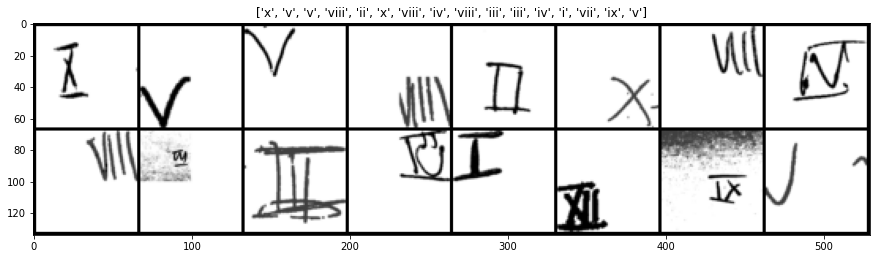

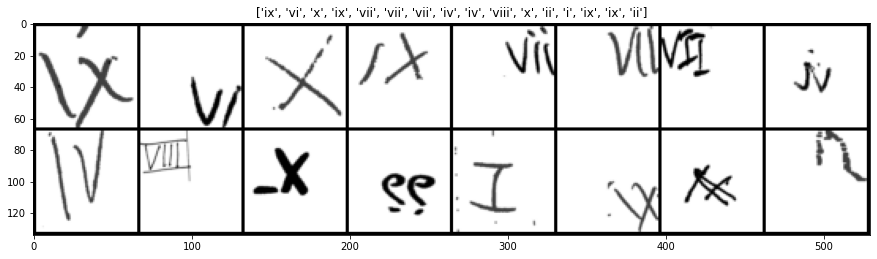

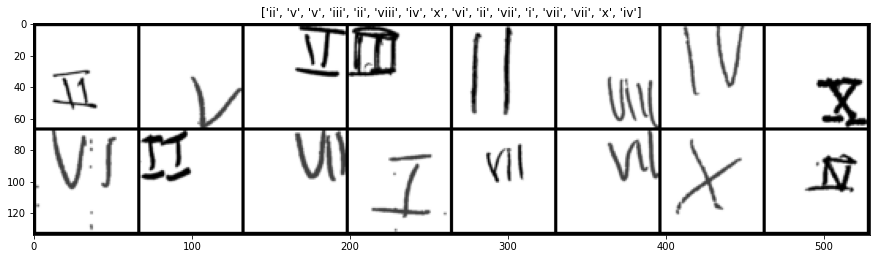

Epoch 1/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.69it/s]


train Loss: 1.8477 Acc: 0.3788


100%|██████████| 25/25 [00:00<00:00, 32.30it/s]


val Loss: 0.9753 Acc: 0.6819

Epoch 2/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.58it/s]


train Loss: 0.7798 Acc: 0.7511


100%|██████████| 25/25 [00:00<00:00, 32.10it/s]


val Loss: 0.5555 Acc: 0.8270

Epoch 3/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.86it/s]


train Loss: 0.5515 Acc: 0.8343


100%|██████████| 25/25 [00:00<00:00, 32.62it/s]


val Loss: 0.6403 Acc: 0.7990

Epoch 4/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.80it/s]


train Loss: 0.4349 Acc: 0.8653


100%|██████████| 25/25 [00:00<00:00, 32.54it/s]


val Loss: 0.5461 Acc: 0.8372

Epoch 5/100
----------


100%|██████████| 600/600 [00:42<00:00, 14.03it/s]


train Loss: 0.3503 Acc: 0.8935


100%|██████████| 25/25 [00:00<00:00, 32.56it/s]


val Loss: 0.6718 Acc: 0.8219

Epoch 6/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.64it/s]


train Loss: 0.1496 Acc: 0.9581


100%|██████████| 25/25 [00:00<00:00, 32.14it/s]


val Loss: 0.2332 Acc: 0.9415

Epoch 7/100
----------


100%|██████████| 600/600 [00:45<00:00, 13.32it/s]


train Loss: 0.0934 Acc: 0.9726


100%|██████████| 25/25 [00:00<00:00, 31.66it/s]


val Loss: 0.2665 Acc: 0.9288

Epoch 8/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.24it/s]


train Loss: 0.0640 Acc: 0.9825


100%|██████████| 25/25 [00:00<00:00, 31.75it/s]


val Loss: 0.2663 Acc: 0.9364

Epoch 9/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.19it/s]


train Loss: 0.0454 Acc: 0.9874


100%|██████████| 25/25 [00:00<00:00, 31.60it/s]


val Loss: 0.3044 Acc: 0.9313

Epoch 10/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.22it/s]


train Loss: 0.0362 Acc: 0.9892


100%|██████████| 25/25 [00:00<00:00, 32.08it/s]


val Loss: 0.3437 Acc: 0.9109

Epoch 11/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.58it/s]


train Loss: 0.0187 Acc: 0.9945


100%|██████████| 25/25 [00:00<00:00, 32.43it/s]


val Loss: 0.2768 Acc: 0.9364

Epoch 12/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.67it/s]


train Loss: 0.0160 Acc: 0.9955


100%|██████████| 25/25 [00:00<00:00, 32.41it/s]


val Loss: 0.2939 Acc: 0.9313

Epoch 13/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.60it/s]


train Loss: 0.0105 Acc: 0.9979


100%|██████████| 25/25 [00:00<00:00, 32.38it/s]


val Loss: 0.2979 Acc: 0.9364

Epoch 14/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.76it/s]


train Loss: 0.0102 Acc: 0.9976


100%|██████████| 25/25 [00:00<00:00, 31.29it/s]


val Loss: 0.2894 Acc: 0.9389

Epoch 15/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.60it/s]


train Loss: 0.0092 Acc: 0.9976


100%|██████████| 25/25 [00:00<00:00, 31.53it/s]


val Loss: 0.2931 Acc: 0.9415

Epoch 16/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.74it/s]


train Loss: 0.0070 Acc: 0.9979


100%|██████████| 25/25 [00:00<00:00, 32.36it/s]


val Loss: 0.2865 Acc: 0.9440

Epoch 17/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.81it/s]


train Loss: 0.0067 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 33.02it/s]


val Loss: 0.3052 Acc: 0.9338

Epoch 18/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.72it/s]


train Loss: 0.0062 Acc: 0.9992


100%|██████████| 25/25 [00:00<00:00, 31.05it/s]


val Loss: 0.2963 Acc: 0.9389

Epoch 19/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.81it/s]


train Loss: 0.0074 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 32.66it/s]


val Loss: 0.3094 Acc: 0.9364

Epoch 20/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.84it/s]


train Loss: 0.0076 Acc: 0.9979


100%|██████████| 25/25 [00:00<00:00, 32.54it/s]


val Loss: 0.3178 Acc: 0.9313

Epoch 21/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.77it/s]


train Loss: 0.0066 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 32.35it/s]


val Loss: 0.3104 Acc: 0.9389

Epoch 22/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.55it/s]


train Loss: 0.0065 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.52it/s]


val Loss: 0.2942 Acc: 0.9415

Epoch 23/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.79it/s]


train Loss: 0.0064 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.14it/s]


val Loss: 0.3070 Acc: 0.9415

Epoch 24/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.75it/s]


train Loss: 0.0077 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.13it/s]


val Loss: 0.2992 Acc: 0.9364

Epoch 25/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.73it/s]


train Loss: 0.0078 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 32.01it/s]


val Loss: 0.3024 Acc: 0.9415

Epoch 26/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.80it/s]


train Loss: 0.0074 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 31.89it/s]


val Loss: 0.2993 Acc: 0.9415

Epoch 27/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.66it/s]


train Loss: 0.0065 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 31.51it/s]


val Loss: 0.3089 Acc: 0.9389

Epoch 28/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.37it/s]


train Loss: 0.0072 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 32.14it/s]


val Loss: 0.3010 Acc: 0.9389

Epoch 29/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.46it/s]


train Loss: 0.0065 Acc: 0.9988


100%|██████████| 25/25 [00:00<00:00, 31.98it/s]


val Loss: 0.3060 Acc: 0.9389

Epoch 30/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.67it/s]


train Loss: 0.0077 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


val Loss: 0.2923 Acc: 0.9415

Epoch 31/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.67it/s]


train Loss: 0.0058 Acc: 0.9990


100%|██████████| 25/25 [00:00<00:00, 33.33it/s]


val Loss: 0.2957 Acc: 0.9389

Epoch 32/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.75it/s]


train Loss: 0.0071 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.14it/s]


val Loss: 0.3108 Acc: 0.9415

Epoch 33/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.75it/s]


train Loss: 0.0075 Acc: 0.9981


100%|██████████| 25/25 [00:00<00:00, 32.28it/s]


val Loss: 0.3084 Acc: 0.9389

Epoch 34/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.82it/s]


train Loss: 0.0072 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 32.29it/s]


val Loss: 0.3013 Acc: 0.9389

Epoch 35/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.74it/s]


train Loss: 0.0058 Acc: 0.9992


100%|██████████| 25/25 [00:00<00:00, 33.05it/s]


val Loss: 0.3078 Acc: 0.9364

Epoch 36/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.55it/s]


train Loss: 0.0065 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.63it/s]


val Loss: 0.2927 Acc: 0.9389

Epoch 37/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.59it/s]


train Loss: 0.0060 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 31.91it/s]


val Loss: 0.2983 Acc: 0.9389

Epoch 38/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.79it/s]


train Loss: 0.0064 Acc: 0.9989


100%|██████████| 25/25 [00:00<00:00, 32.30it/s]


val Loss: 0.2921 Acc: 0.9415

Epoch 39/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.68it/s]


train Loss: 0.0064 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.14it/s]


val Loss: 0.3011 Acc: 0.9364

Epoch 40/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.77it/s]


train Loss: 0.0058 Acc: 0.9990


100%|██████████| 25/25 [00:00<00:00, 32.48it/s]


val Loss: 0.3121 Acc: 0.9389

Epoch 41/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.73it/s]


train Loss: 0.0069 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 32.86it/s]


val Loss: 0.2996 Acc: 0.9415

Epoch 42/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.61it/s]


train Loss: 0.0071 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 32.08it/s]


val Loss: 0.3126 Acc: 0.9415

Epoch 43/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.83it/s]


train Loss: 0.0063 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 32.41it/s]


val Loss: 0.3042 Acc: 0.9415

Epoch 44/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.83it/s]


train Loss: 0.0061 Acc: 0.9989


100%|██████████| 25/25 [00:00<00:00, 32.23it/s]


val Loss: 0.2936 Acc: 0.9440

Epoch 45/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.68it/s]


train Loss: 0.0077 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.18it/s]


val Loss: 0.3038 Acc: 0.9389

Epoch 46/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.88it/s]


train Loss: 0.0073 Acc: 0.9981


100%|██████████| 25/25 [00:00<00:00, 32.12it/s]


val Loss: 0.3098 Acc: 0.9338

Epoch 47/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.63it/s]


train Loss: 0.0066 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 31.14it/s]


val Loss: 0.2993 Acc: 0.9364

Epoch 48/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.47it/s]


train Loss: 0.0065 Acc: 0.9989


100%|██████████| 25/25 [00:00<00:00, 32.16it/s]


val Loss: 0.3044 Acc: 0.9389

Epoch 49/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.32it/s]


train Loss: 0.0068 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 31.56it/s]


val Loss: 0.3079 Acc: 0.9364

Epoch 50/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.64it/s]


train Loss: 0.0078 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.66it/s]


val Loss: 0.2966 Acc: 0.9415

Epoch 51/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.73it/s]


train Loss: 0.0070 Acc: 0.9980


100%|██████████| 25/25 [00:00<00:00, 32.45it/s]


val Loss: 0.3125 Acc: 0.9364

Epoch 52/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.76it/s]


train Loss: 0.0077 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 31.95it/s]


val Loss: 0.2981 Acc: 0.9364

Epoch 53/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.69it/s]


train Loss: 0.0072 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.30it/s]


val Loss: 0.2994 Acc: 0.9389

Epoch 54/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.76it/s]


train Loss: 0.0068 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 31.49it/s]


val Loss: 0.3031 Acc: 0.9364

Epoch 55/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.45it/s]


train Loss: 0.0070 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 30.98it/s]


val Loss: 0.2952 Acc: 0.9415

Epoch 56/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.74it/s]


train Loss: 0.0062 Acc: 0.9988


100%|██████████| 25/25 [00:00<00:00, 27.86it/s]


val Loss: 0.3046 Acc: 0.9389

Epoch 57/100
----------


100%|██████████| 600/600 [00:43<00:00, 13.95it/s]


train Loss: 0.0069 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 27.71it/s]


val Loss: 0.3083 Acc: 0.9364

Epoch 58/100
----------


100%|██████████| 600/600 [00:41<00:00, 14.35it/s]


train Loss: 0.0064 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 29.69it/s]


val Loss: 0.3131 Acc: 0.9364

Epoch 59/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.74it/s]


train Loss: 0.0064 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 30.54it/s]


val Loss: 0.3050 Acc: 0.9389

Epoch 60/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.67it/s]


train Loss: 0.0078 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 28.80it/s]


val Loss: 0.2942 Acc: 0.9415

Epoch 61/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.73it/s]


train Loss: 0.0068 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 31.41it/s]


val Loss: 0.3223 Acc: 0.9389

Epoch 62/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.04it/s]


train Loss: 0.0072 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 31.13it/s]


val Loss: 0.3090 Acc: 0.9415

Epoch 63/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.92it/s]


train Loss: 0.0067 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 30.70it/s]


val Loss: 0.3030 Acc: 0.9389

Epoch 64/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.06it/s]


train Loss: 0.0074 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 30.79it/s]


val Loss: 0.3015 Acc: 0.9389

Epoch 65/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.98it/s]


train Loss: 0.0061 Acc: 0.9991


100%|██████████| 25/25 [00:00<00:00, 30.33it/s]


val Loss: 0.3113 Acc: 0.9389

Epoch 66/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.02it/s]


train Loss: 0.0057 Acc: 0.9990


100%|██████████| 25/25 [00:00<00:00, 30.49it/s]


val Loss: 0.3268 Acc: 0.9389

Epoch 67/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.58it/s]


train Loss: 0.0068 Acc: 0.9983


100%|██████████| 25/25 [00:01<00:00, 22.75it/s]


val Loss: 0.3034 Acc: 0.9389

Epoch 68/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.40it/s]


train Loss: 0.0072 Acc: 0.9976


100%|██████████| 25/25 [00:00<00:00, 32.29it/s]


val Loss: 0.3107 Acc: 0.9364

Epoch 69/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.54it/s]


train Loss: 0.0077 Acc: 0.9981


100%|██████████| 25/25 [00:00<00:00, 32.59it/s]


val Loss: 0.3041 Acc: 0.9415

Epoch 70/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.78it/s]


train Loss: 0.0068 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 33.03it/s]


val Loss: 0.3133 Acc: 0.9415

Epoch 71/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.82it/s]


train Loss: 0.0065 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


val Loss: 0.3031 Acc: 0.9415

Epoch 72/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.72it/s]


train Loss: 0.0068 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 33.00it/s]


val Loss: 0.2986 Acc: 0.9389

Epoch 73/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.92it/s]


train Loss: 0.0059 Acc: 0.9988


100%|██████████| 25/25 [00:00<00:00, 32.47it/s]


val Loss: 0.3091 Acc: 0.9364

Epoch 74/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.68it/s]


train Loss: 0.0060 Acc: 0.9989


100%|██████████| 25/25 [00:00<00:00, 32.96it/s]


val Loss: 0.3123 Acc: 0.9389

Epoch 75/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.92it/s]


train Loss: 0.0073 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 32.92it/s]


val Loss: 0.3032 Acc: 0.9389

Epoch 76/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.89it/s]


train Loss: 0.0081 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 33.34it/s]


val Loss: 0.2991 Acc: 0.9415

Epoch 77/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.91it/s]


train Loss: 0.0071 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 33.29it/s]


val Loss: 0.3067 Acc: 0.9389

Epoch 78/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.78it/s]


train Loss: 0.0066 Acc: 0.9991


100%|██████████| 25/25 [00:00<00:00, 32.34it/s]


val Loss: 0.3120 Acc: 0.9364

Epoch 79/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.87it/s]


train Loss: 0.0062 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 32.10it/s]


val Loss: 0.3092 Acc: 0.9364

Epoch 80/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.62it/s]


train Loss: 0.0062 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.02it/s]


val Loss: 0.3146 Acc: 0.9364

Epoch 81/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.84it/s]


train Loss: 0.0072 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 32.49it/s]


val Loss: 0.2949 Acc: 0.9415

Epoch 82/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.89it/s]


train Loss: 0.0066 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 32.29it/s]


val Loss: 0.3176 Acc: 0.9364

Epoch 83/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.97it/s]


train Loss: 0.0060 Acc: 0.9990


100%|██████████| 25/25 [00:00<00:00, 32.70it/s]


val Loss: 0.3032 Acc: 0.9389

Epoch 84/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.85it/s]


train Loss: 0.0064 Acc: 0.9989


100%|██████████| 25/25 [00:00<00:00, 32.96it/s]


val Loss: 0.3053 Acc: 0.9338

Epoch 85/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.90it/s]


train Loss: 0.0076 Acc: 0.9978


100%|██████████| 25/25 [00:00<00:00, 33.10it/s]


val Loss: 0.3038 Acc: 0.9389

Epoch 86/100
----------


100%|██████████| 600/600 [00:37<00:00, 15.79it/s]


train Loss: 0.0066 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 33.21it/s]


val Loss: 0.3163 Acc: 0.9389

Epoch 87/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.71it/s]


train Loss: 0.0072 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


val Loss: 0.3116 Acc: 0.9313

Epoch 88/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.50it/s]


train Loss: 0.0076 Acc: 0.9984


100%|██████████| 25/25 [00:00<00:00, 32.07it/s]


val Loss: 0.3181 Acc: 0.9364

Epoch 89/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.78it/s]


train Loss: 0.0072 Acc: 0.9983


100%|██████████| 25/25 [00:00<00:00, 31.08it/s]


val Loss: 0.2961 Acc: 0.9440

Epoch 90/100
----------


100%|██████████| 600/600 [00:42<00:00, 14.12it/s]


train Loss: 0.0074 Acc: 0.9981


100%|██████████| 25/25 [00:00<00:00, 27.82it/s]


val Loss: 0.3107 Acc: 0.9338

Epoch 91/100
----------


100%|██████████| 600/600 [00:43<00:00, 13.84it/s]


train Loss: 0.0058 Acc: 0.9986


100%|██████████| 25/25 [00:00<00:00, 26.69it/s]


val Loss: 0.3147 Acc: 0.9389

Epoch 92/100
----------


100%|██████████| 600/600 [00:43<00:00, 13.91it/s]


train Loss: 0.0068 Acc: 0.9982


100%|██████████| 25/25 [00:00<00:00, 28.13it/s]


val Loss: 0.2958 Acc: 0.9389

Epoch 93/100
----------


100%|██████████| 600/600 [00:43<00:00, 13.92it/s]


train Loss: 0.0077 Acc: 0.9979


100%|██████████| 25/25 [00:00<00:00, 28.35it/s]


val Loss: 0.3159 Acc: 0.9364

Epoch 94/100
----------


100%|██████████| 600/600 [00:41<00:00, 14.48it/s]


train Loss: 0.0064 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 28.64it/s]


val Loss: 0.2951 Acc: 0.9415

Epoch 95/100
----------


100%|██████████| 600/600 [00:40<00:00, 14.81it/s]


train Loss: 0.0064 Acc: 0.9988


100%|██████████| 25/25 [00:00<00:00, 31.36it/s]


val Loss: 0.2976 Acc: 0.9440

Epoch 96/100
----------


100%|██████████| 600/600 [00:38<00:00, 15.52it/s]


train Loss: 0.0081 Acc: 0.9979


100%|██████████| 25/25 [00:00<00:00, 32.20it/s]


val Loss: 0.2998 Acc: 0.9364

Epoch 97/100
----------


100%|██████████| 600/600 [00:39<00:00, 15.36it/s]


train Loss: 0.0069 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 27.21it/s]


val Loss: 0.2967 Acc: 0.9389

Epoch 98/100
----------


100%|██████████| 600/600 [00:44<00:00, 13.51it/s]


train Loss: 0.0076 Acc: 0.9980


100%|██████████| 25/25 [00:00<00:00, 26.75it/s]


val Loss: 0.3143 Acc: 0.9415

Epoch 99/100
----------


100%|██████████| 600/600 [00:45<00:00, 13.33it/s]


train Loss: 0.0068 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 27.24it/s]


val Loss: 0.3103 Acc: 0.9338

Epoch 100/100
----------


100%|██████████| 600/600 [00:44<00:00, 13.57it/s]


train Loss: 0.0063 Acc: 0.9985


100%|██████████| 25/25 [00:00<00:00, 27.05it/s]


val Loss: 0.2995 Acc: 0.9415

Training complete in 66m 33s
Best val Acc: 0.944020


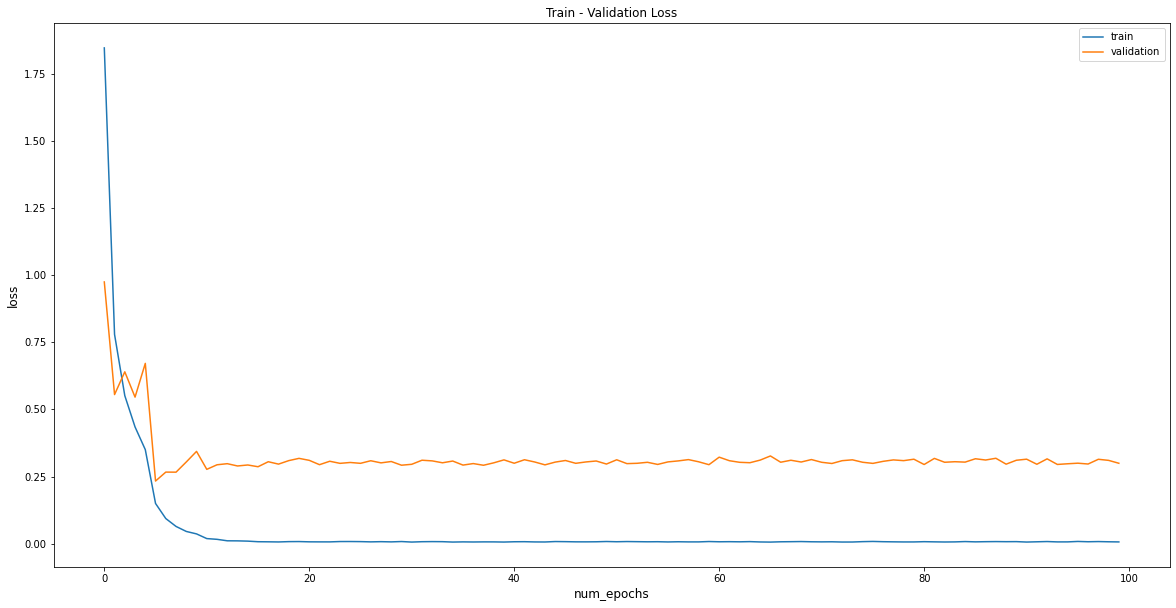

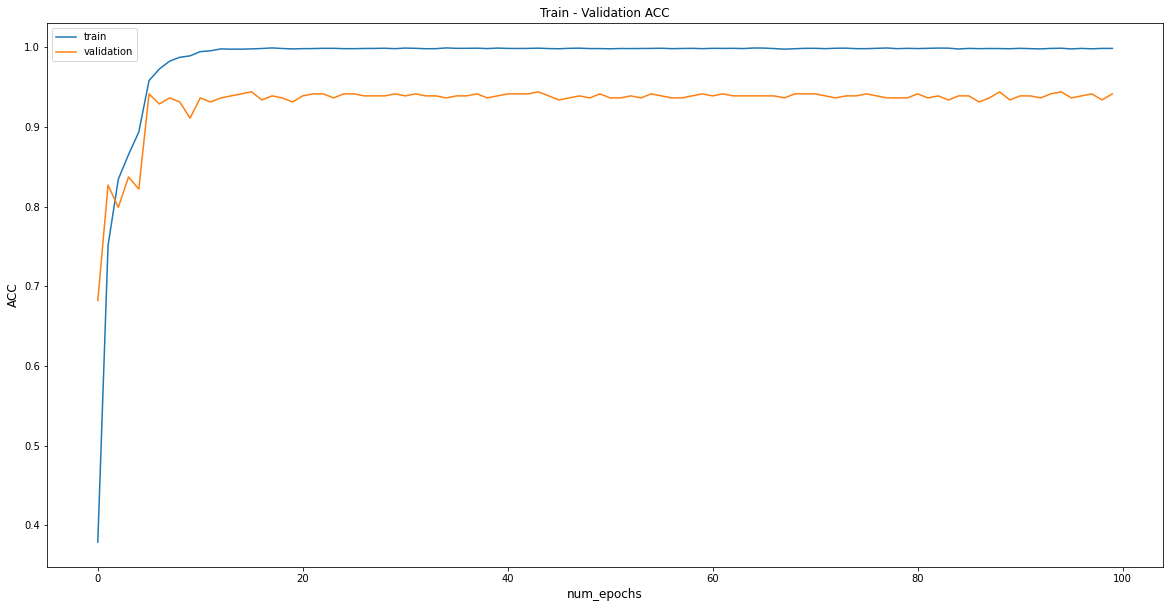

In [11]:
from run_train_eval import *

## Visualize and Analysis

In [6]:
from collections import defaultdict
wrongs = ({('iii', 'vii'): 1, ('ii', 'v'): 1, ('iv', 'vi'): 1, ('iii', 'i'): 1, ('v', 'ii'): 1, ('iv', 'iii'): 2, ('v', 'x'): 2, ('ix', 'x'): 2, ('iii', 'ii'): 2, ('v', 'vi'): 1, ('ii', 'i'): 1, ('ix', 'iv'): 1, ('ii', 'iii'): 2, ('iv', 'ii'): 1, ('vii', 'viii'): 2, ('iv', 'vii'): 1, ('iii', 'vi'): 1, ('iv', 'v'): 1, ('i', 'x'): 1})
grouped = defaultdict(int)
for a, b in wrongs:
  grouped[a] += 1
[(item, grouped[item]) for item in sorted(grouped, key=grouped.get, reverse=True)], sum(wrongs.values())
max(wrongs, key=wrongs.get)

('iv', 'iii')

100%|██████████| 25/25 [00:00<00:00, 26.10it/s]


([('iii', 4),
  ('ii', 2),
  ('iv', 2),
  ('v', 1),
  ('vi', 1),
  ('viii', 1),
  ('ix', 1),
  ('x', 1),
  ('i', 1),
  ('vii', 1)],
 22)

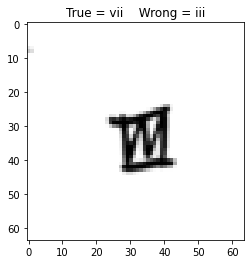

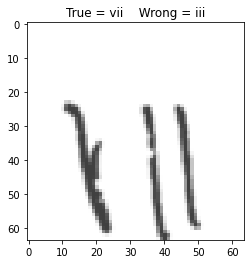

In [12]:
wrongs = defaultdict(int)
with torch.no_grad():
  model = model_ft
  for inputs, labels in tqdm(val_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    pred = outputs.argmax(1)
    for img, y, y_hat in list(zip(inputs[~(labels == pred)], labels[~(labels == pred)], pred[~(labels == pred)])):
      wrongs[(train_dataset.classes[y.item()], train_dataset.classes[y_hat.item()])] += 1
      if not train_dataset.classes[y.item()] == 'vii':
        continue
      plt.figure()
      plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
      plt.title(f'True = {train_dataset.classes[y.item()]}    Wrong = {train_dataset.classes[y_hat.item()]}')

grouped = defaultdict(int)
for a, b in wrongs:
  grouped[a] += 1
[(item, grouped[item]) for item in sorted(grouped, key=grouped.get, reverse=True)], sum(wrongs.values())

In [13]:
for phase in ['before', 'after']:
  if phase == 'before':
    train_dir2 = train_dir
  else:
    train_dir2 = 'original_data'
  with torch.no_grad():
    for inputs, labels in torch.utils.data.DataLoader(datasets.ImageFolder(train_dir2, data_transforms), batch_size=10_000):
      inputs = inputs.to(device)
      labels = labels.to(device).cpu().detach()
      outputs = model(inputs).cpu().detach()


    df = px.data.iris()
    X = outputs

    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    fig = px.scatter(components, x=0, y=1, color=labels.reshape(-1).numpy().astype(str))
    fig.update_layout(title_text='PCA Dimension Reduction - Before Augmentation', title_x=0.5)
    fig.update_xaxes(range=(-50, 150), constrain='domain')
    fig.update_yaxes(range=(-30, 40), constrain='domain')
    fig.show()

In [ ]:
while True:
  pass